# Unsupervised Learning - Emotion Detection
Apply clustering and dimension reduction algorithms, and see how they may help the Neural Netowrk learner

## Import packages

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import (
    accuracy_score, mean_squared_error,
    adjusted_rand_score, adjusted_mutual_info_score,
    homogeneity_score, completeness_score, v_measure_score,
)
import time
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, FastICA
import seaborn as sns
from sklearn.mixture import GaussianMixture
from sklearn.random_projection import GaussianRandomProjection
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

## Load data

In [2]:
data = pd.read_csv('data/emotion-detection/icml_face_data.csv/icml_face_data.csv')
data = data.rename(columns={' Usage': 'Usage', ' pixels': 'pixels'})  # Somehow column names conatin a leading space

## Set aside a test set

In [3]:
train_set = data[data['Usage']=='Training']
test_set = data[data['Usage']=='PrivateTest']
print(len(train_set), 'train istances +', len(test_set), 'test instances')

28709 train istances + 3589 test instances


## Clean data and normalize features

In [4]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_name):
        self.attribute_name = attribute_name
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_name].str.strip('"').str.split(pat=' ', expand=True).values

pipeline = Pipeline([
    ('selector', DataFrameSelector('pixels')),
    ('std_scaler', StandardScaler()),
])

train_X = pipeline.fit_transform(train_set)
train_y = np.array(train_set['emotion'])

## Run clustering algorithms

In [32]:
clustering_algorithm = 'em'
assert clustering_algorithm in {'k_means', 'em'}
n_clusters = 22  # Set to an integer (discovered best n_clusters) or a list of integers (to discover best n_clusters)

In [33]:
def constuct_clustering_model(clustering_algorithm, n_clusters):
    if clustering_algorithm == 'k_means':
        clustering_model = KMeans(random_state=0, n_clusters=n_clusters)
    elif clustering_algorithm == 'em':
        clustering_model = GaussianMixture(random_state=0, n_components=n_clusters)
    return clustering_model

def run_clustering_algorithm(clustering_algorithm, n_clusters):
    if isinstance(n_clusters, int):
        clustering_model = constuct_clustering_model(clustering_algorithm, n_clusters)
        start_time = time.time()
        clustering_model.fit(train_X)
        end_time = time.time()
        print('-----------------------------------------------------------------------')
        print('Result for n_clusters: {}'.format(n_clusters))
        print('Time elapsed (in seconds): {}'.format(end_time - start_time))
        if clustering_algorithm == 'k_means':
            print('Sum of squared distances of samples to their closest cluster center: {}'
                  .format(clustering_model.inertia_))
        elif clustering_algorithm == 'em':
            print('AIC: {0}, and BIC: {1}'.format(clustering_model.aic(train_X), clustering_model.bic(train_X)))
    elif isinstance(n_clusters, list):
        sses = []
        aics = []
        bics = []
        for n in n_clusters:
            clustering_model = constuct_clustering_model(clustering_algorithm, n)
            start_time = time.time()
            clustering_model.fit(train_X)
            end_time = time.time()
            print('-----------------------------------------------------------------------')
            print('Result for n_clusters: {}'.format(n))
            print('Time elapsed (in seconds): {}'.format(end_time - start_time))
            if clustering_algorithm == 'k_means':
                print('Sum of squared distances of samples to their closest cluster center: {}'
                      .format(clustering_model.inertia_))
                sses.append(clustering_model.inertia_)
            elif clustering_algorithm == 'em':
                aic = clustering_model.aic(train_X)
                bic = clustering_model.bic(train_X)
                print('AIC: {0}, and BIC: {1}'.format(aic, bic))
                aics.append(aic)
                bics.append(bic)
        if clustering_algorithm == 'k_means':
            plt.plot(n_clusters, sses)
            plt.title('Sum of squared distances of samples to their closest cluster center')
            plt.xlabel('k')
            plt.ylabel('Sum Squared Error')
        elif clustering_algorithm == 'em':
            plt.plot(n_clusters, aics, label='AIC')
            plt.plot(n_clusters, bics, label='BIC')
            plt.legend(loc='lower right')
            plt.title('AIC or BIC v.s. k')
            plt.xlabel('k')
            plt.ylabel('AIC or BIC')
    else:
        raise ValueError('Invalid argument n_clusters: {}. Only int or list of int supported!'.format(n_clusters))
    return clustering_model
        
clustering_model = run_clustering_algorithm(clustering_algorithm, n_clusters)

-----------------------------------------------------------------------
Result for n_clusters: 22
Time elapsed (in seconds): 263.0972602367401
AIC: -222114231.28000754, and BIC: 261126996.0476355


In [34]:
def eval_clustering_result(train_y, pred_y):
    print('Adjusted rand score: {}'.format(adjusted_rand_score(train_y, pred_y)))
    print('Adjusted mutual information score: {}'.format(adjusted_mutual_info_score(train_y, pred_y)))
    print('Homogeneity score: {}'.format(homogeneity_score(train_y, pred_y)))
    print('Completeness score: {}'.format(completeness_score(train_y, pred_y)))
    print('V-measure score: {}'.format(v_measure_score(train_y, pred_y)))
    
pred_y = clustering_model.predict(train_X)
eval_clustering_result(train_y, pred_y)

Adjusted rand score: 0.005243870429707445
Adjusted mutual information score: 0.015537330085035954
Homogeneity score: 0.022124704064532787
Completeness score: 0.013061509447542318
V-measure score: 0.01642586696995975


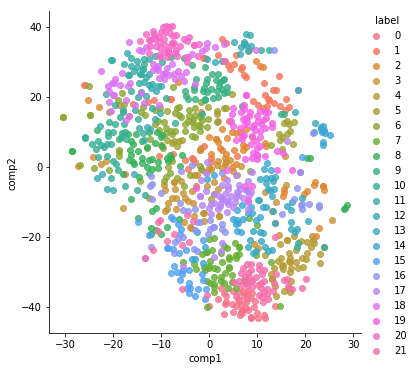

In [35]:
def sample_rows(X, y, num_rows_to_sample):
    num_total_rows = X.shape[0]
    random_indices = np.random.choice(num_total_rows, size=num_rows_to_sample, replace=False)
    return X[random_indices, :], y[random_indices]

reduced_X = PCA(n_components=50).fit_transform(train_X)
sampled_X, sampled_y = sample_rows(reduced_X, pred_y, 1000)
embedded_X = TSNE(n_components=2).fit_transform(sampled_X)
df_tsne = pd.DataFrame(embedded_X, columns=['comp1', 'comp2'])
df_tsne['label'] = sampled_y
sns.lmplot(x='comp1', y='comp2', data=df_tsne, hue='label', fit_reg=False)

## Run dimensionality reduction algorithms

In [62]:
dr_algorithm = 'lda'
assert dr_algorithm in {'pca', 'ica', 'random_projection', 'lda'}
n_components = 5

In [63]:
def construct_dr_model(dr_algorithm, n_components):
    if dr_algorithm == 'pca':
        dr_model = PCA(random_state=0, n_components=n_components)
    elif dr_algorithm == 'ica':
        dr_model = FastICA(random_state=0, n_components=n_components)
    elif dr_algorithm == 'random_projection':
        dr_model = GaussianRandomProjection(random_state=0, n_components=n_components)
    elif dr_algorithm == 'lda':
        dr_model = LinearDiscriminantAnalysis(n_components=n_components)
    return dr_model

dr_model = construct_dr_model(dr_algorithm, n_components)
reduced_X = dr_model.fit_transform(train_X, train_y)

In [64]:
if dr_algorithm == 'pca' or dr_algorithm == 'ica':
    reconstructed_X = dr_model.inverse_transform(reduced_X)
    print('MSE between original data and reconstructed data: {}'.format(mean_squared_error(train_X, reconstructed_X)))

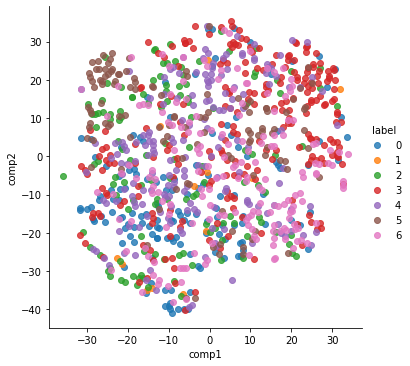

In [65]:
def sample_rows(X, y, num_rows_to_sample):
    num_total_rows = X.shape[0]
    random_indices = np.random.choice(num_total_rows, size=num_rows_to_sample, replace=False)
    return X[random_indices, :], y[random_indices]

sampled_X, sampled_y = sample_rows(reduced_X, train_y, 1000)
embedded_X = TSNE(n_components=2).fit_transform(sampled_X)
df_tsne = pd.DataFrame(embedded_X, columns=['comp1', 'comp2'])
df_tsne['label'] = sampled_y
sns.lmplot(x='comp1', y='comp2', data=df_tsne, hue='label', fit_reg=False)

## Optimize Neural Network weights by randomized optimization

In [5]:
# Construct neural network model and specify optimizer
algorithm = 'gradient_descent'  # CHNAGE ALGORITHM HERE
algorithm_specific_parameters = {
    'gradient_descent': {
        'max_iters': 100,
        'max_attempts': 10,
    },
    'random_hill_climb': {
        'max_iters': 1000,
        'max_attempts': 100,
        'restarts': 5,
    },
    'simulated_annealing': {
        'max_iters': 10000,
        'max_attempts': 100,
        'schedule': mlrose.ExpDecay(),
    },
    'genetic_alg': {
        'max_iters': 100,
        'max_attempts': 10,
        'pop_size': 200,
        'mutation_prob': 0.4,
    },
}
nn = mlrose.NeuralNetwork(
    # Common parameters
    algorithm=algorithm,
    hidden_nodes=[512],  # Besides hidden nodes, num of input nodes = 2304 and num of output nodes = 7
    activation='relu',
    bias=True,
    is_classifier=True,
    learning_rate=0.0001,
    early_stopping=True,
    clip_max=5,
    random_state=0,
    curve=True,
    # Parameters specific to algorithm
    **algorithm_specific_parameters[algorithm]
)

In [6]:
# Fit to learn weights
start_time = time.time()
nn.fit(train_X, one_hot_train_y)
end_time = time.time()
print('Time elapsed (in seconds): {}'.format(end_time - start_time))
print('Minimized log loss (negative of fitness): {}'.format(np.min(-nn.fitness_curve)))

Time elapsed (in seconds): 31.177410125732422
Minimized log loss (negative of fitness): 7.350652169090731


In [7]:
# Predict and evaluate on train set
pred_y = nn.predict(train_X)
print('Train accuracy: {}'.format(accuracy_score(one_hot_train_y, pred_y)))

Train accuracy: 0.7407665505226481


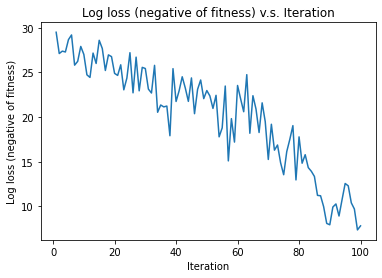

In [8]:
# Plot fitness curve
def plot_fitness_curve(fitness_curve):
    iters = list(range(1, len(fitness_curve) + 1))
    plt.plot(iters, fitness_curve)
    plt.title('Log loss (negative of fitness) v.s. Iteration')
    plt.xlabel('Iteration')
    plt.ylabel('Log loss (negative of fitness)')
    plt.show()
    
plot_fitness_curve(-nn.fitness_curve)  # Note: mlrose derives fitness by flipping the sign of log loss

## Evaluate the model on the test set

In [9]:
# Predict and evaluate on test set
test_X = pipeline.transform(test_set)
test_y = np.array(test_set['emotion'])
one_hot_test_y = one_hot.transform(test_y.reshape(-1, 1)).todense()
pred_y = nn.predict(test_X)
print('Test accuracy: {}'.format(accuracy_score(one_hot_test_y, pred_y)))

Test accuracy: 0.2750069657286152


## Plot train/test accuracy v.s. log loss (negative of fitness)

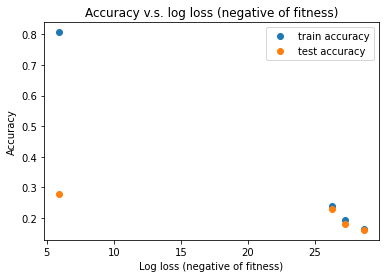

In [10]:
labels = ['Gradient Descent', 'Random Hill Climbing', 'Simulated Annealing', 'Genetic Algorithm']
log_losses = [5.9288, 27.2341, 28.6343, 26.2833]
train_accuracies = [0.8070, 0.1923, 0.1624, 0.2383]
test_accuracies = [0.2784, 0.1814, 0.1610, 0.2279]

plt.plot(log_losses, train_accuracies, label='train accuracy', marker='o', linestyle = 'None')
plt.plot(log_losses, test_accuracies, label='test accuracy', marker='o', linestyle = 'None')
plt.title('Accuracy v.s. log loss (negative of fitness)')
plt.xlabel('Log loss (negative of fitness)')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')

Text(0, 0.5, 'AIC')

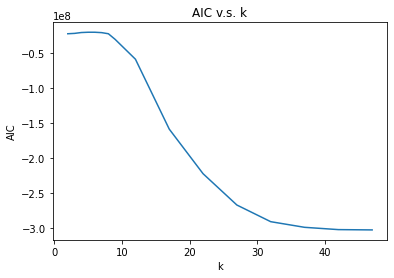

In [31]:
ks = [2, 3, 4, 5, 6, 7, 8, 9, 12, 17, 22, 27, 32, 37, 42, 47]
aics = [
    -22786227, -22268370, -21047018, -20639959, -20645531, -21186225, -22776226, -30798420,
    -59034047, -158605842, -222114231, -266712281, -290427949, -298452091, -301724395, -302160510,
]
plt.plot(ks, aics)
plt.title('AIC v.s. k')
plt.xlabel('k')
plt.ylabel('AIC')